# Dünya Bankası veri tabanından enerji verileri çekmek ve otomatik model belirlenmesi

Barış Sanlı, [www.barissanli.com](http://www.barissanli.com)   [barissanli2@gmail.com](mailto:barissanli2@gmail.com)

Niye Excel değil de R? Gerçekte R veya Python veya başka bir dil tercihim özel olarak yok. Sadece bir dili kullananların sayısı ne kadar çok ise o kadar fazla soruya daha hızlı cevap bulabiliyoruz. 

Excel değil de R sorusu "elma" ile "armut" kıyaslaması gibi gelebilir. Fakat bu derste Excel ile veri temizleme hazırlama, model seçimi gibi bir çok sorunun R ile ne kadar hızlı halledilebileceğini göreceğiz.

Bunun için Dünya Bankası veri bankasını kullanacağız. Sırası ile:
* Dünya Bankası veri setine erişmek için "wbstats" kütüphanesini kuracağız
* Veri kütüphanesinden, kişi başı gelir, nüfus ve enerji göstergelerini çekeceğiz
* Bu değişkenlerin birbiri ile ilintisine bakacağız
* Grafikleyeceğiz, hatta "The Economist" temasını kullanacağız
* Son olarak da otomatik doğrusal regresyon modeli belirleyerek, modeli kuracağız


## "wbstats" kütüphanesi

wbstats, Dünya Bankası veri tabanına erişmeyi kolaylaştıran bir R kütüphanesi. Daha önce NOAA ve EIA veritabanlarında görüldüğü gibi API anahtarı almaya gerek yok.

Doğrudan veri talep ediyoruz.

Eğer kütüphane daha önce kurulmadıysa:

In [ ]:
install.packages("wbstats")

ile bu kütüphaneyi kurabiliriz. Açıklamalar konusunda wbstats rehberine bakabilirsiniz. https://cran.r-project.org/web/packages/wbstats/wbstats.pdf

Eğer kütüphaneyi kurarken bir sorun yaşamadıysanız, her zaman olduğu gibi *library* komutu ile bu kütüphaneyi devreye alabiliriz. 

Verileri çekerken ise sadece göstergelerin kodlarını vektör olarak **indicator** parametresine girmemiz yeterli. Bu çalışmada benim araştırma sorum:

***"Küresel olarak elektrikte kömür kullanımı hangi parametrelerle nasıl ilişkili, kömürü az kullanmak bir kalkınmışlık göstergesi mi?"***

sorusu. Dünya Bankasındaki tüm ülkelerin yıllara sair verileri üzerinden kömür, nüfus, ekonomik büyüme ve diğer kaynaklar ile ilişkisini bulmaya çalışacağız.

Önce Kütüphanemizi yükleyelim:

In [1]:
library(wbstats)

## Aradığımız Veri kodlarını bulmak

Herhangi bir veriyi sistemden çekebilmek için veri kodunu bilmemiz gerekiyor. Mesela elektrik üretimindeki kömürün oranı *"EG.ELC.COAL.ZS"* gibi biraz garip bir kod. Dolayısıyla önce veritabanında doğru kodları bulmamız gerekiyor. 

Bunun için **wbsearch** komutunu kullanacağız. Komuta aradığımız anahtar kelimeleri yazınca bizlere o konu ile ilgili tüm kodları getirecek. Burada **indicatorID** sütunu altında yer alan kod ise sistemden talep edeceğimz verinin kodu.

Şimdi elektrik ile ilgili veri kodlarını bulmaya çalışalım

In [2]:
wbsearch("electricity production")

,indicatorID,indicator
11101,EG.ELC.RNWX.ZS,"Electricity production from renewable sources, excluding hydroelectric (% of total)"
11102,EG.ELC.RNWX.KH,"Electricity production from renewable sources, excluding hydroelectric (kWh)"
11104,EG.ELC.PETR.ZS,Electricity production from oil sources (% of total)
11105,EG.ELC.NUCL.ZS,Electricity production from nuclear sources (% of total)
11106,EG.ELC.NGAS.ZS,Electricity production from natural gas sources (% of total)
11108,EG.ELC.HYRO.ZS,Electricity production from hydroelectric sources (% of total)
11109,EG.ELC.FOSL.ZS,"Electricity production from oil, gas and coal sources (% of total)"
11110,EG.ELC.COAL.ZS,Electricity production from coal sources (% of total)
15804,4.1.2_REN.ELECTRICITY.OUTPUT,Renewable energy electricity output (GWh)
15956,12.1_TD.LOSSES,Transmission and distribution losses (%)


## Dünya Bankası Web sayfasından verileri bulmak

Dünya Bankası kütüphaneleri ile ilgili İngilizce sitelere de bakmak faydalı olabilir. Mesela : https://cengel.github.io/gearup2016/worldbank.html gibi.

Ana olarak WorldBank data catalog:  https://data.worldbank.org/ adresinden erişilebilir. Burada zaten bir kaç kelime yazınca verinin adı otomatik geliyor. Veriye tıklayınca da açılan sayfanın **adres** kısmında verinin ismi gözüküyor.

Örneğin: Nüfus için https://data.worldbank.org/indicator/SP.POP.TOTL adresinin sonundaki "SP.POP.TOTL" veri kodudur. Benim hangi verileri kullanacağımı bulmak haftalar sürdü, sonra kodlarını bulmak dakikalar. Çünkü Dünya Bankası veri seti çok geniş. Bunun sonucunda:

* Kişi başı satın alma pariteli GSYİH   "NY.GDP.PCAP.PP.KD"
* Nüfus   "SP.POP.TOTL"
* Elektrik üretiminde doğalgaz oranı  "EG.ELC.NGAS.ZS"
* Elektrik üretiminde kömür oranı  "EG.ELC.COAL.ZS"
* Elektrik üretiminde yenilenebilir oranı  "EG.ELC.RNEW.ZS"
* Toplam elektrik üretimi  "4.1.1_TOTAL.ELECTRICITY.OUTPUT"
* Elektriğe şehirde erişim oranı  "EG.ELC.ACCS.UR.ZS"
* Elektriğe kırsalda erişim oranı  "EG.ELC.ACCS.RU.ZS"
* Toplam nihai enerji tüketimi   "1.1_TOTAL.FINAL.ENERGY.CONSUM"
* Yenilenebilirin toplam enerji tüketimindeki oranı  "2.1_SHARE.TOTAL.RE.IN.TFEC" 

Tabii ki istediğim başka veriler de oldu, ama bu ders için çekemedim. Bunun veri çekme sınırından mı, verinin kendisinden mi kaynaklandığı başka bir problem.

Yukarıdaki verileri alarak **wb_dat** değişkenine alıyoruz. Verilerin gelmesi zaman alabilir, biraz bekleyin, veriler gelince de gelen verinin başlıklarına **names** komutu ile bir bakın

In [3]:
wb_dat <- wb(indicator = c("NY.GDP.PCAP.PP.KD", "EG.ELC.NGAS.ZS","EG.ELC.COAL.ZS", 
                           "EG.ELC.ACCS.RU.ZS","EG.ELC.ACCS.UR.ZS", "EG.ELC.RNEW.ZS",
                           "2.1_SHARE.TOTAL.RE.IN.TFEC" , 
                           "1.1_TOTAL.FINAL.ENERGY.CONSUM", "SP.POP.TOTL",
                           "4.1.1_TOTAL.ELECTRICITY.OUTPUT" ,  "12.1_TD.LOSSES ",
                           "4.1.2_REN.ELECTRICITY.OUTPUT ", "11.1_THERMAL.EFFICIENCY "
                                                     )) 
names(wb_dat)

Warning message in wb(indicator = c("NY.GDP.PCAP.PP.KD", "EG.ELC.NGAS.ZS", "EG.ELC.COAL.ZS", :
“The following indicator values are not valid and are being excluded from the request: 12.1_TD.LOSSES ,4.1.2_REN.ELECTRICITY.OUTPUT ,11.1_THERMAL.EFFICIENCY ”No encoding supplied: defaulting to UTF-8.
Warning message:
“JSON string contains (illegal) UTF8 byte-order-mark!”No encoding supplied: defaulting to UTF-8.
Warning message:
“JSON string contains (illegal) UTF8 byte-order-mark!”

[1] "value"       "date"        "indicatorID" "indicator"   "iso2c"      
[6] "country"


Veri setimizin üst kısmına bir bakalım. Neler varmış? Bir de ben internetten çektiğim veriyi daima başka bir değişkene de **(wb2)** aktarıyorum ki mevcut veriyi değiştirirken yanlışlık yaparken orjinal veriyi tekrar internete bağlanmadan yükleyebileyim.


In [4]:
head(wb_dat)
wb2<-wb_dat

value,date,indicatorID,indicator,iso2c,country
15533.69,2016,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World
15328.98,2015,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World
15140.19,2014,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World
15037.57,2013,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World
14852.63,2012,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World
14463.51,2011,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2011 international $)",1A,Arab World


## Veri ile işlem yapmak ve sütunlara bölmek


Bir de Dünya Bankası veri tabanında yer alan ülkelerin isim ve bilgilerini alalım. Çünkü gelen veri seti, çok kompakt, yani kaç veri istersek isteyelim değerler hep "value" sütununda, veri ismi de "indicator" sütununda. Burada değişkenleri sütunlara yaymamız gerekecek.

Önce sistemdeki tüm ülkelerin isimlerini *wbcountries()*  komutu ile çekerek başlıklarına *names* komutu ile bakalım.

In [5]:
wb_countries <- wbcountries() 
names(wb_countries)

[1] "iso3c"     "iso2c"     "country"   "capital"   "long"      "lat"      
 [7] "regionID"  "region"    "adminID"   "admin"     "incomeID"  "income"   
[13] "lendingID" "lending"


Verilerdeki bölge değişkenlerini *iso2c* altında birleştirelim


In [6]:
wb_dat <- merge(wb_dat, y = wb_countries[c("iso2c", "region")], by = "iso2c", all.x = TRUE)

wb_dat <- subset(wb_dat, region != "Aggregates") # this also removes NAs




Şimdi bu karışık kodlara ait verileri yeni isimlendirdiğimiz sütunlara çekelim. Öncelikle "NY.GDP.PCAP.PP.KD" kodunu **GDP** olarak değiştirelim. Bu yöntem yerine ayırıp sonra sütun isimlendirme de yapılabilir. Bunu web'den aldığım bir koddan değiştirerek uyguladım, daha güvenli bir yöntem olabilir.

Önce kodları isimlendirelim


In [11]:
wb_dat$indicatorID[wb_dat$indicatorID == "NY.GDP.PCAP.PP.KD"] <- "GDP"
wb_dat$indicatorID[wb_dat$indicatorID == "EG.ELC.NGAS.ZS"] <- "gas"
wb_dat$indicatorID[wb_dat$indicatorID == "EG.ELC.COAL.ZS"] <- "coal"
wb_dat$indicatorID[wb_dat$indicatorID == "EG.ELC.RNEW.ZS"] <- "renewables"
wb_dat$indicatorID[wb_dat$indicatorID == "EG.ELC.ACCS.UR.ZS"] <- "urbanaccess"
wb_dat$indicatorID[wb_dat$indicatorID == "EG.ELC.ACCS.RU.ZS"] <- "ruralaccess"
wb_dat$indicatorID[wb_dat$indicatorID == "SP.POP.TOTL"] <- "population"
wb_dat$indicatorID[wb_dat$indicatorID == "4.1.1_TOTAL.ELECTRICITY.OUTPUT"] <- "electricityGWh"
wb_dat$indicatorID[wb_dat$indicatorID == "2.1_SHARE.TOTAL.RE.IN.TFEC"] <- "reinTFEC"
wb_dat$indicatorID[wb_dat$indicatorID == "1.1_TOTAL.FINAL.ENERGY.CONSUM"] <- "TFEC"

Eğer yüklü değil ise "reshape2" kütüphanesini kurmamız gerekir bunun için de

In [12]:
install.packages("reshape2")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done



Ben de zaten kurulu olduğundan **reshape2** kütüphanesinden **dcast** komutu ile *indicatorID* sütunundaki daha önce isimlendirdiğim tüm verileri karşılık gelen değerleri ile ayrı sütunlara çeviriyorum, yeni veri matrisini tekrar **wb_dat** olarak adlandırıyorum.


In [13]:
library(reshape2)
wb_dat <- dcast(wb_dat, iso2c + country + date  ~ indicatorID,  value.var = 'value')

Şimdi veriye baktığımız zaman, *head(wb_dat)* ile, ayrı sütunlarda her bir ülke için 1960 dan buyana tüm verilerin gruplandığını göreceğiz.

In [14]:
head(wb_dat)

iso2c,country,date,coal,electricityGWh,gas,GDP,population,reinTFEC,renewables,ruralaccess,TFEC,urbanaccess
AD,Andorra,1960,NA,NA,NA,NA,13411,NA,NA,NA,NA,NA
AD,Andorra,1961,NA,NA,NA,NA,14375,NA,NA,NA,NA,NA
AD,Andorra,1962,NA,NA,NA,NA,15370,NA,NA,NA,NA,NA
AD,Andorra,1963,NA,NA,NA,NA,16412,NA,NA,NA,NA,NA
AD,Andorra,1964,NA,NA,NA,NA,17469,NA,NA,NA,NA,NA
AD,Andorra,1965,NA,NA,NA,NA,18549,NA,NA,NA,NA,NA



Şimdi de veri setimizin bir özetine bakalım, görüldüğü üzere 12377 adet veri satırından oluşmakta, ama bunların bir kısmı boş ya da eksik veri. Ayrıca burada verilerimizin hangi aralıkta yer aldığı, ortamalarının ne olduğu da rahatlıkla görülebilir.


In [15]:
summary(wb_dat)

    iso2c             country              date                coal        
 Length:12377       Length:12377       Length:12377       Min.   :  0.000  
 Class :character   Class :character   Class :character   1st Qu.:  0.000  
 Mode  :character   Mode  :character   Mode  :character   Median :  0.115  
                                                          Mean   : 17.593  
                                                          3rd Qu.: 28.102  
                                                          Max.   :100.000  
                                                          NA's   :6447     
 electricityGWh         gas               GDP             population       
 Min.   :      0   Min.   :  0.000   Min.   :   247.4   Min.   :4.279e+03  
 1st Qu.:    504   1st Qu.:  0.000   1st Qu.:  2776.5   1st Qu.:4.491e+05  
 Median :   5786   Median :  1.507   Median :  8182.8   Median :4.047e+06  
 Mean   :  82302   Mean   : 17.703   Mean   : 15247.4   Mean   :2.379e+07  
 3rd Qu.:  3

## Veri setinden bir kısım seçmek

Hazır veri setimiz tam iken burada bir komut ile değişkenlerimizi diske saklayalım. Bunun için **saveRDS** komutu yeterli olacaktır. Komutun kullanımı çok basit, doğrudan komutu yazıp, değişkeni ve dosya ismini yazıp saklıyoruz. 


In [1]:
#saveRDS(wb_dat,"ulkeverileri.rds")
wb_dat<-readRDS("ulkeverileri.rds")


Tüm veri setimiz görüldüğü üzere oldukça geniş. Ben analiz için daha çok 2000 yılı sonrası verilerini kullanmak istiyorum, bu sebeple **wb_dat** verisinden *2000 yılı*  sonrası verilerini seçerek, **wb_dat** verisine geri yüklüyorum. Artık **wb_dat** da sadece 2000 yılından sonraki veriler var.


In [2]:
# yıl veya değer seçelim
wb_dat<-subset(wb_dat,date>2000)


Şimdi de yeni bir veri çerçevesi oluşturarak, sütunları tekrar isimlendirelim. Bu işleme gerek olmayabilir, ama olaki siz de benim gibi belki bir çok veri tabanından veri çekerseniz bu şekilde bir birleştirme gerekebilir. **colnames** komutu ile de sütunlara isimlerini verelim.

**data_set** isimli verisetimize baktığımız zaman ise bir sürü olmayan veri *(NA)*lar göreceğim. Hatırlarsanız yukarıda Andorra'nın 1960'dan başlayan veri setleri yoktu. En üstte hep bu ülkenin 1960lı yıllar verileri olduğundan bu veriler olmayabilir.


In [3]:
data_set<-data.frame(wb_dat$coal,wb_dat$gas, wb_dat$GDP, 
                     wb_dat$ruralaccess, wb_dat$urbanaccess, wb_dat$renewables, wb_dat$TFEC, wb_dat$reinTFEC,
                     wb_dat$electricityGWh, wb_dat$population)
colnames(data_set)<-c("coal","gas","gdp","raccess","uaccess", "ren","TFEC","renTFEC","elec","pop")
head(data_set)

coal,gas,gdp,raccess,uaccess,ren,TFEC,renTFEC,elec,pop
NA,NA,NA,100,100,100.00000,8776.12,15.77387,80,67341
NA,NA,NA,100,100,100.00000,8962.05,16.22182,80,70049
NA,NA,NA,100,100,100.00000,9087.87,16.91231,80,73182
NA,NA,NA,100,100,98.93617,9616.47,16.87442,94,76244
NA,NA,NA,100,100,98.82353,9827.60,16.90244,85,78867
NA,NA,NA,100,100,94.59459,9458.98,17.48600,74,80991


## NA olmayan verileri bulmak

Normalde NA, yani olmayan verileri, birçok yöntemle elimine edebiliriz. Burada ben herhangi bir satırda **NA** var ise o satırın çıkmasını isteyeceğim. Bunun için de **complete.cases** komutunu kullanıyoruz. Tüm sütunlarında veri olan satırların numarasınız *complete.cases(data_set)* ile *nasiz_veriler* değişkenine atarak başlığına bakıyoruz.


In [4]:
nasiz_veriler<-data_set[complete.cases(data_set),]

head(nasiz_veriler)
str(nasiz_veriler)

,coal,gas,gdp,raccess,uaccess,ren,TFEC,renTFEC,elec,pop
17,0,97.20189,99283.97,100,100,0,1094811,0.06470585,43172,3326032
18,0,97.23621,96445.70,100,100,0,1063553,0.06660754,46856,3507232
19,0,97.25581,98351.85,100,100,0,1067512,0.06636053,49450,3741932
20,0,97.66488,98639.85,100,100,0,1041348,0.10056218,52417,4087931
21,0,97.86484,92325.52,100,100,0,1110510,0.10539482,60698,4579562
22,0,97.96759,88592.30,100,100,0,1126147,0.12033808,66768,5242032


'data.frame':	1797 obs. of  10 variables:
 $ coal   : num  0 0 0 0 0 0 0 0 0 0 ...
 $ gas    : num  97.2 97.2 97.3 97.7 97.9 ...
 $ gdp    : num  99284 96446 98352 98640 92326 ...
 $ raccess: num  100 100 100 100 100 100 100 100 100 100 ...
 $ uaccess: num  100 100 100 100 100 100 100 100 100 100 ...
 $ ren    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ TFEC   : num  1094811 1063553 1067512 1041348 1110510 ...
 $ renTFEC: num  0.0647 0.0666 0.0664 0.1006 0.1054 ...
 $ elec   : num  43172 46856 49450 52417 60698 ...
 $ pop    : num  3326032 3507232 3741932 4087931 4579562 ...


## Yeni sütunlar eklemek veya hesaplamak

Bu bilgisayar işlerinin sağı solu belli olmadığından, ben "nasiz_veriler" değişkeni üzerinde değil, değişkeni kopyaladığım *nasiz_veriler2* değişkeni üzerinden işleme devam edeceğim. Bu çalışmalar esnasında genelde bir R defteri haftalarca değiştirildiğinden ben her aşamada veri yedekliyorum. 

Ardından GDP ve TFEC ve daha sonra elec verilerinin logarithmalarını hesaplayacağım için bu sütunlarda 1'den büyük değerleri alıyorum. 0'dan büyük değerleri almam matematiksel olarak yeterli ama 1'den büyük alarak güvenilir tarafta kalıyorum. 3.sütun GDP, 7.sütun da TFEC(total final energy consumption, nihai enerji tüketimi). Bu iki sütunun da 1'den büyük olduğu satırları alıyorum.

Kodlama stili olarak ben genelde KISS, kullanıyorum, yani zekice birşey yapmamaya çalışıyorum. Sadece adım adım neyi değiştirince ne olduğu, nasıl geliştiğini görmeye çalışıyorum. Burada c(3,7) ve & ile mantıksal operatör de kullanılabilir belki. Ama ben bildiğim ve hatayı izleyebileceğim yolu tercih ediyorum


In [5]:
nasiz_veriler2<-nasiz_veriler
nasiz_veriler2<-nasiz_veriler2[nasiz_veriler2[,7]>1.0,]
nasiz_veriler2<-nasiz_veriler2[nasiz_veriler2[,3]>1.0,]



Şimdi de sütunlar hesaplayalım. R'da veri çerçevesinde yeni bir sütun eklemek kolay. Sadece yeni sütun ismini yazarak, içinde ne olması gerektiğini belirtiyorsunuz. İlk satırda görüleceği üzere, *nasiz_veriler2* 'deki *TFEC* sütununun logarithmasını alarak *logTFEC* diye bir sütun oluşturuyorum. 3.satırda 1 milyon ile çarpma sebebi, değişkenin GWh olması ben ise birey başına kWh elektrik üretimi vs hesaplayacağım. Bu sebeple GWh'i kWh'e çeviriyorum.

Tüm hesaplamalardan sonra değişkene tekrar bakalım


In [6]:
nasiz_veriler2$logTFEC<-log(nasiz_veriler2$TFEC)
nasiz_veriler2$logGDP<-log(nasiz_veriler2$gdp)
nasiz_veriler2$elecPerPop<-(nasiz_veriler2$elec/nasiz_veriler2$pop)*1000000
nasiz_veriler2$TFECPerPop<-nasiz_veriler2$TFEC/nasiz_veriler2$pop
nasiz_veriler2$logelec<-log(nasiz_veriler2$elec)
head(nasiz_veriler2)

,coal,gas,gdp,raccess,uaccess,ren,TFEC,renTFEC,elec,pop,logTFEC,logGDP,elecPerPop,TFECPerPop,logelec
17,0,97.20189,99283.97,100,100,0,1094811,0.06470585,43172,3326032,13.90609,11.50574,12980.03,0.3291642,10.67295
18,0,97.23621,96445.70,100,100,0,1063553,0.06660754,46856,3507232,13.87713,11.47674,13359.82,0.3032457,10.75483
19,0,97.25581,98351.85,100,100,0,1067512,0.06636053,49450,3741932,13.88084,11.49631,13215.10,0.2852836,10.80872
20,0,97.66488,98639.85,100,100,0,1041348,0.10056218,52417,4087931,13.85603,11.49923,12822.38,0.2547372,10.86699
21,0,97.86484,92325.52,100,100,0,1110510,0.10539482,60698,4579562,13.92033,11.43308,13254.11,0.2424926,11.01367
22,0,97.96759,88592.30,100,100,0,1126147,0.12033808,66768,5242032,13.93431,11.39180,12737.05,0.2148302,11.10898


## Verilerin birbiri ile ilişkisine bakmak

İlinti ya da korelasyonlara bakmak için veri çerçevesini **cor** komutuna vermemiz yeterli. Her sütunun diğer sütunlar ile ilişkisine bakan *cor* komutu ile hangi değişken hangi diğer değişken ile ne kadar ilintili bulmak mümkün

In [7]:
cor(nasiz_veriler2)

,coal,gas,gdp,raccess,uaccess,ren,TFEC,renTFEC,elec,pop,logTFEC,logGDP,elecPerPop,TFECPerPop,logelec
coal,1.000000000,-0.261782608,0.008915929,0.13925305,0.08416806,-0.35369806,0.200841733,-0.23831820,0.20282121,0.20901505,0.2113924,0.15144407,0.03231992,0.03185769,0.2556653
gas,-0.261782608,1.000000000,0.355058660,0.27824013,0.20048949,-0.44551200,-0.004535371,-0.40007522,-0.02315521,-0.01810256,0.1643392,0.28482819,0.08394210,0.29147930,0.1693078
gdp,0.008915929,0.355058660,1.000000000,0.49904071,0.36114213,-0.28323847,0.112946632,-0.47941041,0.14314760,-0.09299423,0.1822398,0.83935269,0.66837784,0.83036604,0.3299064
raccess,0.139253046,0.278240128,0.499040709,1.00000000,0.79249114,-0.29709381,0.127181333,-0.76981992,0.14968063,-0.02553701,0.2398547,0.75684022,0.44657826,0.47712544,0.5584610
uaccess,0.084168064,0.200489486,0.361142128,0.79249114,1.00000000,-0.23349210,0.103710325,-0.63127741,0.11595795,0.02107449,0.2023922,0.61911319,0.31895058,0.34193818,0.4808204
ren,-0.353698059,-0.445511998,-0.283238466,-0.29709381,-0.23349210,1.00000000,-0.118045803,0.64381247,-0.11584177,-0.07102768,-0.1690611,-0.34994276,-0.02247325,-0.17864452,-0.1907525
TFEC,0.200841733,-0.004535371,0.112946632,0.12718133,0.10371033,-0.11804580,1.000000000,-0.13043040,0.99164041,0.64211737,0.5690264,0.14866422,0.13773432,0.19145506,0.5141908
renTFEC,-0.238318198,-0.400075216,-0.479410407,-0.76981992,-0.63127741,0.64381247,-0.130430404,1.00000000,-0.15393453,0.03857272,-0.2068436,-0.70270640,-0.24143457,-0.37583027,-0.4558480
elec,0.202821209,-0.023155214,0.143147597,0.14968063,0.11595795,-0.11584177,0.991640406,-0.15393453,1.00000000,0.58421828,0.5447574,0.18140677,0.17653823,0.21652002,0.5133002
pop,0.209015048,-0.018102558,-0.092994234,-0.02553701,0.02107449,-0.07102768,0.642117369,0.03857272,0.58421828,1.00000000,0.4792109,-0.08492774,-0.07016338,-0.07055796,0.3944635


## Korelasyon tablosunu incelemek

Benim çalışmadaki amacım, herkesin iddia ettiği gibi petrolün, kömürün sonunun gelip gelmediği ve hangi değişkenlerden etkilendiği. *"Mesela kömür gelişmede bir adım mıdır?"* sorusuna cevap da, ilinti oranı çok düşük **0.02**'tür. Yani geliştikçe daha az kömür tüketilir diye birşey söylenemez. Aksine hem **ren** yani elektrikteki yenilenebilir oranı ve **renTFEC** nihai enerji talebindeki yenilenebilir oranının katsayıları (negatif)'dir. Yani gelişmiş ülkeler yenilenebiliri sanki daha az kullanan ülkelerdir. Yalnız ilintide sebep sonuç mümkün değildir. Gelişmişlik mesela en çok kişi başı elektrik, enerji ve kırsal da elektriğe erişim ile ilintilidir.

Peki kömür kullanımına dair bir doğrusal regresyon yapsak hangi değişkenlerden kurmamız gerekir. 

Bunun için otomatik bir model seçimi yapacağız.

## Otomatik regresyon modeli seçme

Dersin bu kısmı biraz **İLERİ SEVİYE**. Eğer zor geliyorsa, bir sonraki kısımda grafikleme kısmına geçebilirsiniz.

Tüm değişken ve ilinti tablolarını oluşturduktan sonra, ülkelerin kömür kullanım oranları hangi değişkenlerle ilgili bunu bulmak için **"leaps"** paketini kullanabiliriz. Bunun için önce paketi yüklemek gereki

* *install.packages("leaps")*

Paketi yükledikten sonra asıl komutumuz **regsubsets**. Ben aşağıda bu kütüphane için kullandığım web adreslerini de verdim. 

* **regsubsets(coal ~ . , data=nasiz_veriler2**   şeklinde devam eden aşağıdaki komutta kömür değişkeninin tüm veri setindeki diğer değişkenlerden hangilerine bağlı olduğunu parametrelerle hesaplatıyoruz.


In [65]:
#--------------------------------------
#best model selection for coal
#-------------------------------------
# web: https://rstudio-pubs-static.s3.amazonaws.com/2897_9220b21cfc0c43a396ff9abf122bb351.html

# install.packages("leaps")

require(leaps)

results<-regsubsets(coal ~ ., data = nasiz_veriler2, nvmax = 1000, nbest=1)



Şimdi ise sonuçları görelim. Öncelikle:

* *summary(results)*  komutu ile sonuçların özetini alalım
* *which.max(results.summary$adjr2)*  komutu ile Adjusted R2 (düzeltilmiş r-kare)'ye göre em iyi sonucu bul diyoruz
* *results.by.adjr2* komutu ile hangi denklemin en iyi sonucu verdiğini ekrana yazıyoruz
* *plot* komutu ile de hangi değişkenler ile en yüksek R2 elde edildiğini çizdiriyoruz

In [66]:
results.summary<-summary(results)
results.by.adjr2 <- which.max(results.summary$adjr2)
results.by.adjr2
results.summary$adjr2[169]
results.summary$which[results.by.adjr2,]


[1] 13

[1] NA

(Intercept)         gas         gdp     raccess     uaccess         ren 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
       TFEC     renTFEC        elec         pop     logTFEC      logGDP 
      FALSE        TRUE        TRUE        TRUE        TRUE        TRUE 
 elecPerPop  TFECPerPop     logelec 
       TRUE        TRUE        TRUE


Yukarıda kodlama açısından tüm değişkenleri ekleyerek sadece TFEC değişkenini kabul etmediğini gördük. TFEC değişkeninşi kabul etmeden elde edilen en yüksek yakınsama değeri 0.445'tir. Bunu da ekrana yazdırdıktan sonra, sonuçları ekrana çizelim. 

Birşeye dikkat etmekte fayda var, otomatik seçimde modelin doğruluğu değil belirtilen yakınsamaya bakılıyor. Yani R2 veya BIC değerlerini minimum veya maksimum yapan değerler seçiliyor.


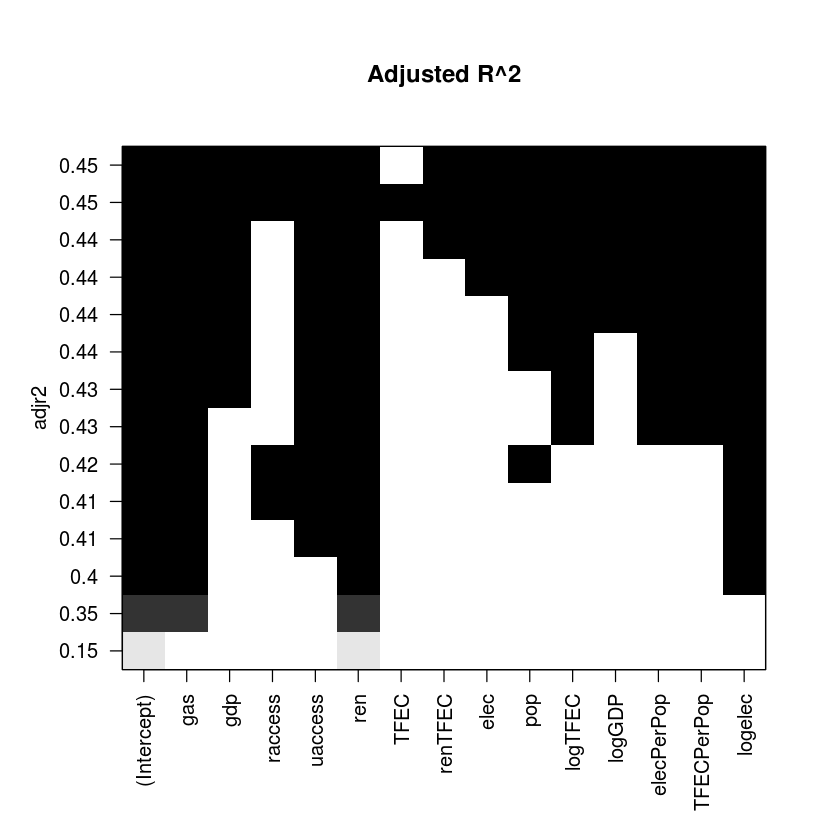

In [67]:
plot(results , scale = "adjr2", main = "Adjusted R^2")

Görüldüğü üzere en yüksek R2, TFEC değişkeni dışarıda bırakıldığı durumda elde ediliyor.

## Verileri Grafiklendirmek için *ggplot2* ve *ggthemes*

*ggplot2* kütüphanesi grafikleme açısından en popüler kütüphanelerden biridir. Ben buna ek olarak *"ggthemes"* kütüphanesini de kullanıyorum. Arada raporlar daha iyi gözüksün diye bu kütüphanedeki "The Economist" veya "Wall Street Journal" temalarını seçiyorum. 

Aşağıdaki grafikleme de "The Economist"'in beyaz temasını kullanacağız.

Yoksa, önce ggplot2 ve ggthemes'i kuralım


In [ ]:
install.packages("ggplot2")
install.packages("ggthemes")

Şimdi de kurduğumuz kütüphaneleri kullanalım

In [8]:
library(ggplot2)
library(ggthemes)


Şimdi öncelikle veri setimizde gaz ve kömürün elektrikte payı 0'dan, kişi başı elektrik kullanımı da 1000 kWh'dan büyük olan veri satırları için işlem yapacağız. Bunun için *subset* komutunu kullanıyoruz. Filtreleme için ise "gas>1", mantıksal operatör olarak da **"&"** kullanılıyor. Yani 3 değişkende de belirli bir sınırın üzerini istiyoruz

2.satırda bu veri kümesinde, 
* x ekseninde toplam elektrik tüketiminin logaritması
* y ekseninde kömürün elektrik üretimindeki payı
* renk farklılaştırması için de GSYİH(gayri safi yurt içi hasıla)'yı kullanıyoruz. Daha zengin daha açık renk

3.satırdaki *theme_economist_white()* komutu ile de meşhur derginin beyaz temasını seçiyoruz.


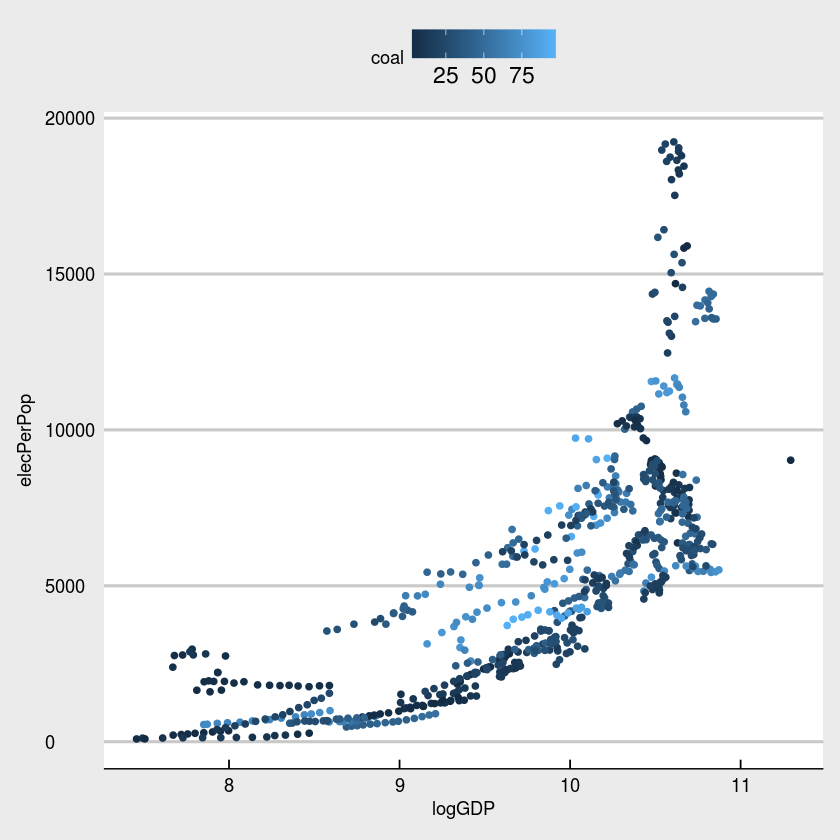

In [43]:
ggplot(subset(nasiz_veriler2, gas>1 & coal>1), 
       aes(x = logGDP, y = elecPerPop, colour= coal ) ) +
       theme_economist_white() + geom_point()


Şimdi bir tane de elektrik tüketimine bakmadan gelişmişlik ile Toplam Nihai Enerji Tüketimindeki yenilenebilir oranına bakalım. Renk skalası da logaritmik toplam enerji tüketimi olsun


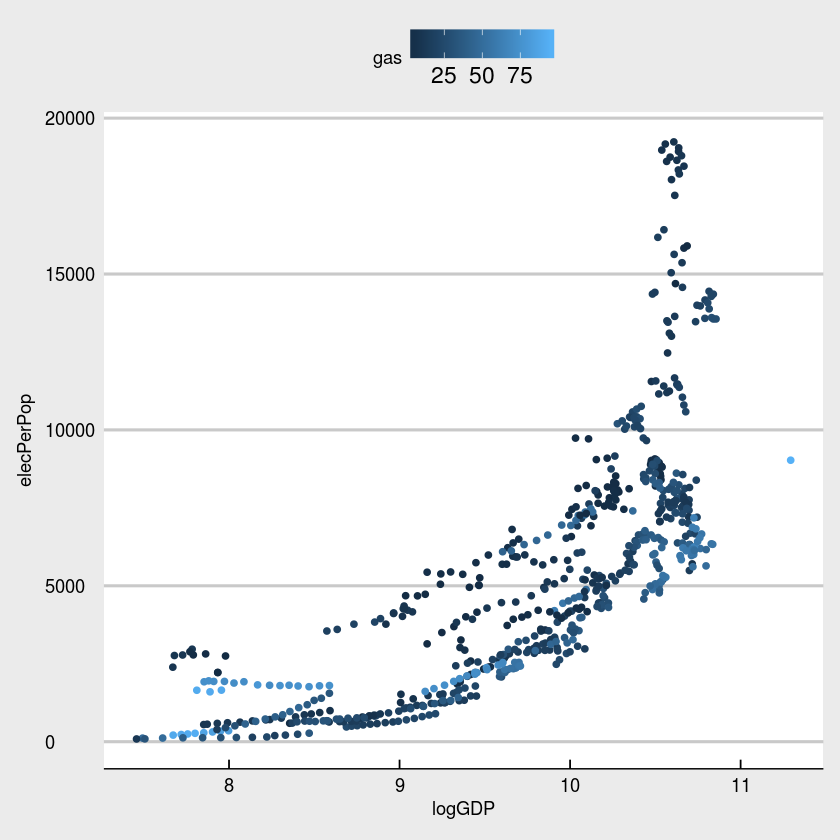

In [18]:
#ggplot(subset(wb_dat, gas>1 & coal>1 ), aes(x = log(GDP, y = log(TFEC), colour=ruralaccess ) ) + geom_point()
ggplot(subset(nasiz_veriler2, gas>1 & coal>1 & ren>1 ), 
       aes(x = logGDP, y = elecPerPop, colour= gas          ) ) +
       theme_economist_white() + geom_point()

# Sonuç

Bu derste daha karışık daha profesyonel bir analiz denedik. Herşeyi anlamak kolay olmayabilir. Fakat kısaca neler yaptığımıza bakalım

* Dünya Bankasından veri almayı gördük
* Bu verileri genişleterek düzgün sütunlu veri çerçeveleri oluşturduk
* Verilerin bibirbir ile ilişkilerinin incelendiği ilinti matrisi hesaplandı
* "leaps" paketi ile otomatik model değişkenleri seçtik
* Grafikleme ve profesyonel tema kullanımını inceledik

Sanıyorum bu kısımda bir çok soru oluşmuştur. Daha kısa kodlarla bu egzersiz yapılabilirmiydi? Sanırım evet
Önerilerinizi bekliyorum [barissanli2@gmail.com](mailto:barissanli2@gmail.com)


# EK 

Otomatik model seçimi konusunda meraklı olanlar için aşağıda bir de **meifly** kütüphanesi ile otomatik model seçimi denemesi var:

In [75]:
#install.packages("meifly")
library(meifly)

In [ ]:
# coal~gas+raccess+uaccess+ren+pop+logelec,data=nasiz_veriler2
# https://rstudio-pubs-static.s3.amazonaws.com/2897_9220b21cfc0c43a396ff9abf122bb351.html
fitall.out <- fitall(y = nasiz_veriler2$coal,
                     x = nasiz_veriler2[,c(2,3,4,5,6,7,8,9,10,11,12,13)])

Fitting 16383 models...


In [ ]:
fitall.out.aic <- t(sapply(fitall.out, extractAIC))

## Create an order list of increasing AIC
final.out.order <- order(fitall.out.aic[,2])

## Show the result for the best model
fitall.out[final.out.order][1]


In [313]:
summary(fitall.out[final.out.order[1]])

,df,logL,AIC,BIC,R2,adjR2,n,model
m8465,6,-580.7239,-1173.448,-1190.745,0.4155712,0.397164,132,8465
